# Homework 2
#### Noah Franz
#### Due: 10/3/24

## Problem 1

In [168]:
import pandas as pd
import numpy as np
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import dynesty

In [169]:
col_names = [
    "name",
    "ra_hours",
    "ra_minutes",
    "ra_seconds",
    "dec_degrees",
    "dec_arcminutes",
    "dec_arcseconds",
    "E(B-V)",
    "dist_mod",
    "dist_mod_up",
    "dist_mod_low",
    "vrad",
    "vrad_up",
    "vrad_low",
    "Vmag",
    "Vmag_up",
    "Vmag_low",
    "PA",
    "PA_up",
    "PA_low",
    "e",
    "e_up",
    "e_low",
    "muVo",
    "muVo_up",
    "muVo_low",
    "rh",
    "rh_up",
    "rh_low",
    "sigma_s",
    "sigma_s_up",
    "sigma_s_low",
    "vrot_s",
    "vrot_s_up",
    "vrot_s_low",
    "M_HI",
    "sigma_g",
    "sigma_g_up",
    "sigma_g_low",
    "vrot_g",
    "vrot_g_up",
    "vrot_g_low",
    "Fe_H",
    "Fe_H_up",
    "Fe_H_low",
    "F",
    "refs"
]

nearby_galaxies = pd.read_csv("NearbyGalaxies.dat", skiprows=37, sep=" ", index_col=False, names=col_names)
n_og = len(nearby_galaxies)
nearby_galaxies = nearby_galaxies[(nearby_galaxies.Vmag != 999) * (nearby_galaxies.dist_mod != 999)]
print(f"Cut out {n_og-len(nearby_galaxies)} galaxies for poor Vmag or poor Distance Modulus")

vmags, dist_mod = nearby_galaxies.Vmag, nearby_galaxies.dist_mod
abs_mag = (vmags - dist_mod).to_list()

# add the milky way
abs_mag.append(-20.6) # from https://lweb.cfa.harvard.edu/~dfabricant/huchra/seminar/galaxies/

# and add M31
abs_mag.append(-21.5) # from https://arxiv.org/abs/astro-ph/0511045

print(abs_mag)

Cut out 2 galaxies for poor Vmag or poor Distance Modulus
[-14.389999999999999, -13.500000000000002, -2.5, -2.410000000000002, -4.709999999999999, -2.8999999999999986, -1.3000000000000007, -2.3999999999999986, -3.879999999999999, 0.019999999999999574, -1.799999999999999, -4.5, -4.25, -2.9400000000000013, -1.8599999999999994, -2.5299999999999994, -4.379999999999999, -3.51, -5.750000000000002, -3.200000000000001, -3.9200000000000017, -18.12, -1.6099999999999994, -3.8000000000000007, -5.229999999999999, -16.830000000000002, -6.02, -8.709999999999999, -9.03, -1.5600000000000023, -3.5500000000000007, -3.3000000000000007, -10.820000000000002, -2.370000000000001, -9.270000000000001, -0.33000000000000185, -3.3099999999999987, -3.3200000000000003, -5.119999999999999, -4.359999999999999, -9.43, -3.469999999999999, -8.200000000000001, -3.4499999999999993, -5.830000000000002, -4.600000000000001, -9.030000000000001, -13.46, -4.990000000000002, -5.17, -4.399999999999999, -4.220000000000002, -4.5, -4

Text(0.5, 0, 'Absolute V-Band Magnitude')

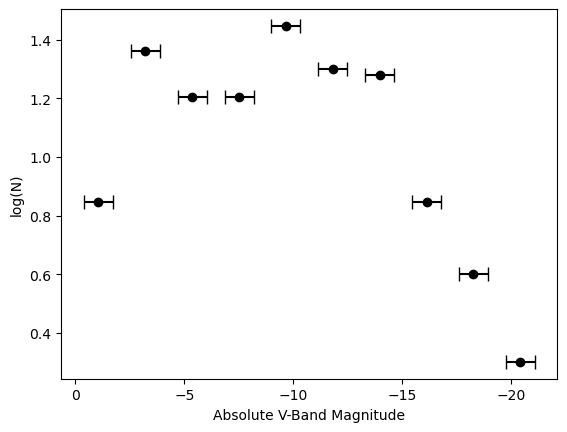

In [437]:
# reformat the data
nbins = 10
counts, bins = np.histogram(
    abs_mag, 
    bins=nbins
)

mids = 0.5*(bins[1:] + bins[:-1])
probs = counts / np.sum(counts)

mean = np.sum(probs * mids)  
sd = np.log10(np.sqrt(np.sum(probs * (mids - mean)**2)))

# plot the N vs. Luminosity
fig, ax = plt.subplots()
ax.errorbar(mids, np.log10(counts), xerr=sd, capsize=5, color='k', linestyle="none", marker="o")

# some other labels
fig.gca().invert_xaxis()

ax.set_ylabel("log(N)")
ax.set_xlabel("Absolute V-Band Magnitude")

In [442]:
# fit with a schechter function

x = 10**(-0.4*mids)
y = np.log10(counts)
yerr = 1 # so +/- 1 count per bin
xerr = sd

def schechter(L_V, phi_star, log_L_V_star, alpha):

    L_V_star = 10**log_L_V_star
    f1 = (L_V / L_V_star)**alpha
    f2 = np.exp(-L_V/L_V_star)
    phi = phi_star * f1 * f2
    return phi

# log-likelihood
def loglike(theta):
    phi_star, log_L_V_star, alpha = theta

    # select a random value for x within it's uncertainty
    xin = np.random.normal(x,xerr)
    #print(xin)
    
    model = schechter(xin, phi_star, log_L_V_star, alpha)
    inv_sigma2 = 1.0 / (err**2 + model**2)
    res = -0.5 * (np.sum((y-model)**2 * inv_sigma2 - np.log(inv_sigma2)))
    return res

# prior transform
def prior_transform(utheta):
    u_phi_star, u_L_V_star, u_alpha = utheta
    phi_star = (u_phi_star * 50) + 30
    L_V_star = (u_L_V_star * 1) + 7
    alpha = (u_alpha*0.05)
    
    return phi_star, L_V_star, alpha

dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=3,
                                        bound='multi', sample='rwalk')
dsampler.run_nested()
dres = dsampler.results

1370it [00:00, 4264.52it/s, batch: 0 | bound: 0 | nc: 13 | ncall: 7023 | eff(%): 18.211 | loglstar:   -inf < -32.891 <    inf | logz: -35.675 +/-  0.056 | dlogz:  3.902 >  0.010]/tmp/ipykernel_6172/2782508245.py:11: RuntimeWarning: invalid value encountered in power
  f1 = (L_V / L_V_star)**alpha
6238it [00:04, 1266.94it/s, batch: 1 | bound: 12 | nc: 23 | ncall: 108468 | eff(%):  5.490 | loglstar: -33.460 < -31.457 < -31.144 | logz: -34.102 +/-  0.071 | stop:  3.419]       /tmp/ipykernel_6172/2782508245.py:11: RuntimeWarning: invalid value encountered in power
  f1 = (L_V / L_V_star)**alpha
6375it [00:04, 1293.06it/s, batch: 1 | bound: 13 | nc: 23 | ncall: 111619 | eff(%):  5.459 | loglstar: -33.460 < -31.254 < -31.144 | logz: -34.102 +/-  0.071 | stop:  3.419]/tmp/ipykernel_6172/2782508245.py:11: RuntimeWarning: invalid value encountered in power
  f1 = (L_V / L_V_star)**alpha
11241it [00:06, 1383.23it/s, batch: 5 | bound: 18 | nc: 23 | ncall: 172064 | eff(%):  6.475 | loglstar: -36.3

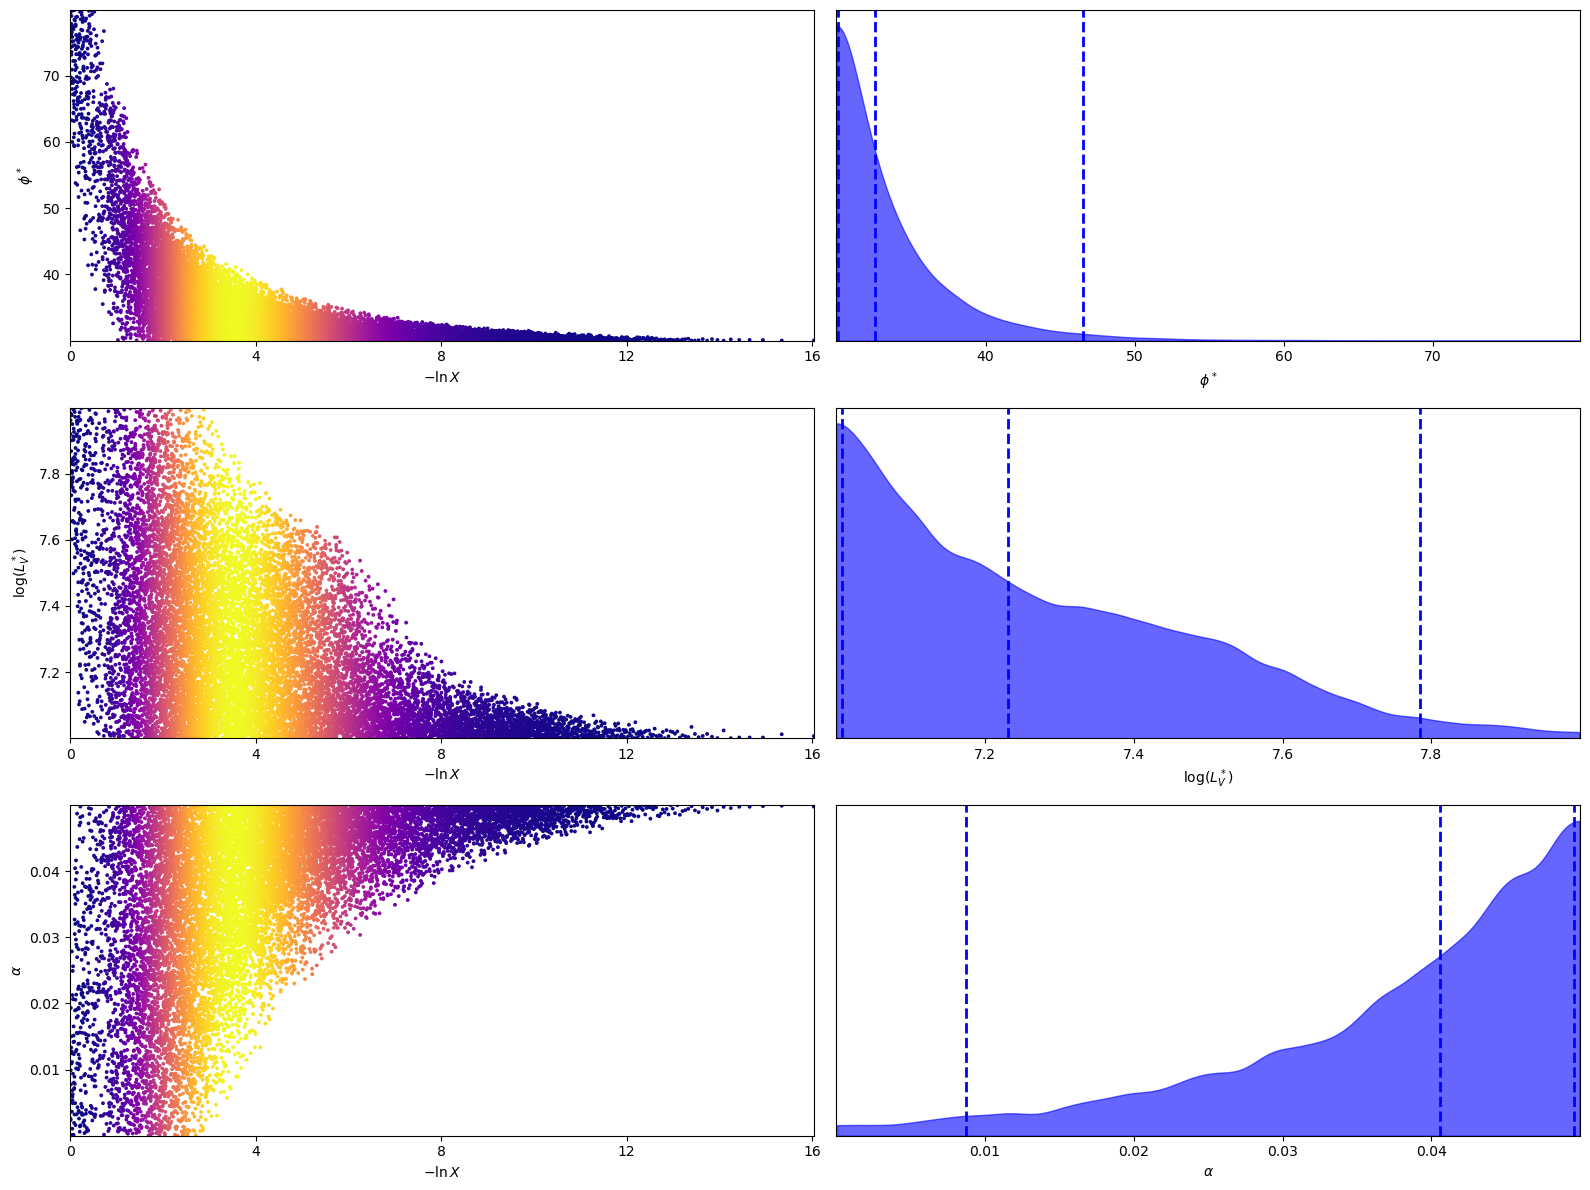

In [443]:
from dynesty import plotting as dyplot

labels = [r'$\phi^*$', r'$\log(L_V^*)$', r'$\alpha$']
fig, axes = dyplot.traceplot(dsampler.results, labels=labels,
                             fig=plt.subplots(3, 2, figsize=(16, 12)))
fig.tight_layout()

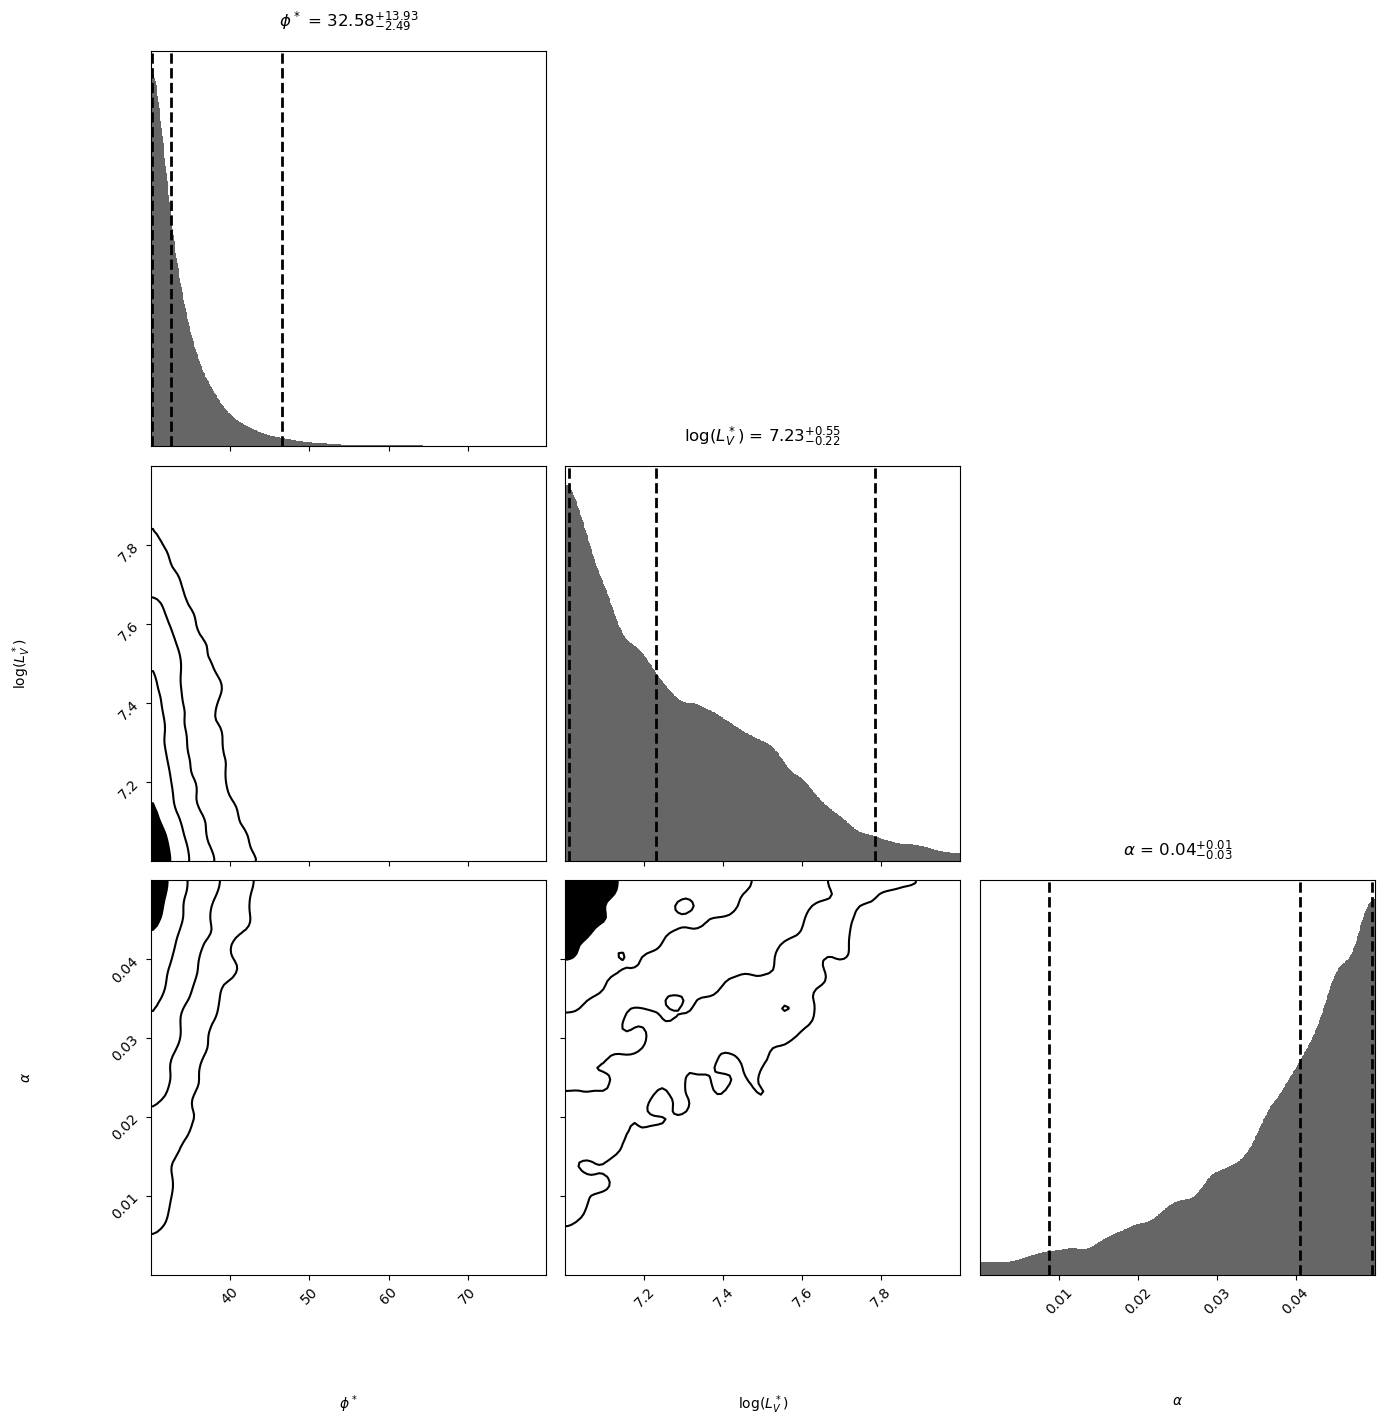

In [444]:
fig, axes = dyplot.cornerplot(dres,show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(3, 3, figsize=(15, 15)))

[30.01603221  7.012852    0.04940963]
[30.23622199  7.00434813  0.04968944]
[30.1110716   7.00026826  0.04917406]
[30.00205624  7.02342858  0.04972538]
[30.1980247   7.00019536  0.04954486]
[30.11136927  7.00211487  0.04973378]
[30.11136927  7.00211487  0.04973378]
[30.09517256  7.00219982  0.04982916]
[30.01719077  7.01186177  0.04989747]
[30.02302162  7.00630902  0.04975218]


/tmp/ipykernel_6172/2166052696.py:13: RuntimeWarning: divide by zero encountered in log10
  ax.plot(-2.5*np.log10(xfit), np.log10(model), color='k', alpha=0.25)


(5.0, -30.0)

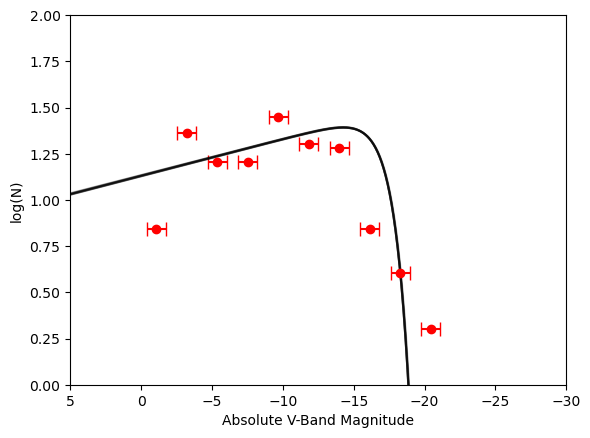

In [449]:
n = 10
res = dres["samples"][-n:]
xfit = 10**(-0.4*np.linspace(-30, 5, 1000))

# plot the N vs. Luminosity
fig, ax = plt.subplots()
ax.errorbar(-2.5*np.log10(x), y, xerr=sd, capsize=5, color='r', linestyle="none", marker="o")

for vals in res:
    print(vals)
    
    model = schechter(xfit, *vals)
    ax.plot(-2.5*np.log10(xfit), np.log10(model), color='k', alpha=0.25)

# some other labels
fig.gca().invert_xaxis()

ax.set_ylabel("log(N)")
ax.set_xlabel("Absolute V-Band Magnitude")

ax.set_ylim(0, 2)
ax.set_xlim(5, -30)

In [452]:
# Extract sampling results.
samples = dres.samples  # samples
weights = dres.importance_weights()

# Compute 10%-90% quantiles.
quantiles = [dynesty.utils.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dynesty.utils.mean_and_cov(samples, weights)

In [462]:
for m, q, lab in zip(mean, quantiles, labels):
    print(r"${lab} = {m:.2f}^{{ +{q0:.2f} }}_{{ -{q1:.2f} }}$".format(lab=lab, m=m, q0=q[1]-m, q1=m-q[0]))

$$\phi^*$ = 34.03^{ +5.41 }_{ -3.64 }$
$$\log(L_V^*)$ = 7.28^{ +0.31 }_{ -0.25 }$
$$\alpha$ = 0.04^{ +0.01 }_{ -0.02 }$


# Problem 3

In [664]:
lambda_eff = 7980*u.AA # https://www.astronomy.ohio-state.edu/martini.10/usefuldata.html
f0_I = 112.6e-11 * u.erg * u.cm**-2 * u.s**-1 * u.AA**-1 # https://www.astronomy.ohio-state.edu/martini.10/usefuldata.html # 

def convert_sigma(sigma_mag, lambda_eff=lambda_eff, f0=f0_I):
    sigma = f0_I * 10**(-0.4*sigma_mag) * u.arcsec**-2
    val_cgs = sigma * 4*np.pi * lambda_eff * (1*u.pc**2).to(u.cm**2) / u.pc**2
    return val_cgs / c.L_sun.cgs * u.arcsec**2
    
convert_sigma(15)

<Quantity 2.80853802e-07 1 / pc2>

# Problem 4

In [634]:
r_e = 269.3
mu_e = 23.37
n = 6

def sersic_linear_space(r, n=n, r_e=r_e, mu_e=mu_e):
    """Returns I"""
    b_n = 2*n - 1/3
    f = np.exp( -b_n * ((r/r_e)**(1/n) - 1) )
    print(b_n, f, ((r/r_e)**(1/n) - 1))
    return mu_e * f 

def sersic(r, n=n, r_e=r_e, mu_e=mu_e):
    """Taken from http://burro.case.edu/Academics/Astr323/Lectures/GalaxyPopulations.pdf pg. 17"""
    b_n = 2*n - 1/3
    mu = mu_e + 2.5*b_n/np.log(10) * ((r/r_e)**(1/n) - 1)
    return mu

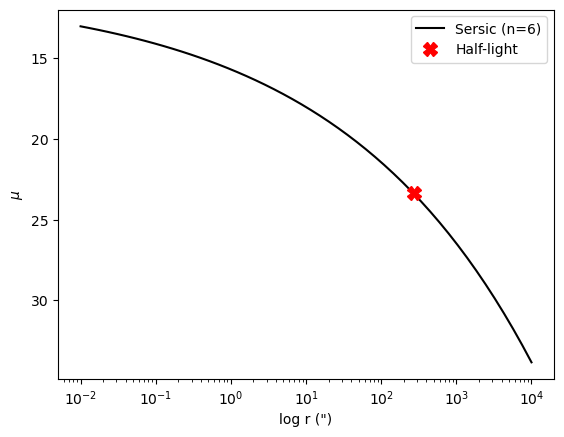

In [635]:
r = np.logspace(-2, 4) # arcsec
mu = sersic(r)

fig, ax = plt.subplots()
ax.plot(r, mu, 'k-', label=f"Sersic (n={n})")

ax.set_xscale("log")
ax.set_ylabel(r"$\mu$")
ax.set_xlabel(r'log r (")')

ax.plot([r_e], [mu_e], 'rX', markersize=10, label="Half-light")

ax.legend()

fig.gca().invert_yaxis(); # because magnitudes

In [636]:
I = (10**(-0.4*21.9))
dI = 0.005*I
dmu_plus = -2.5*np.log10(I + dI)
dmu_minus = -2.5*np.log10(I-dI)

dmu_plus, dmu_minus

(21.89458484560873, 21.905442298135686)

In [648]:
from scipy import integrate as si
    
si.quad(sersic, 0, np.inf)

/tmp/ipykernel_6172/3396597617.py:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  si.quad(sersic, 0, np.inf)


(-10.70299123359639, 0.0005198153545062922)